<a href="https://colab.research.google.com/github/yemanzhongting/MultiCity/blob/main/City2POI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/language.csv /content

In [ ]:
!cp /content/language.csv /content/data

In [8]:
import pandas as pd
poi=pd.read_csv('/content/language.csv')

In [ ]:
sview=pd.read_csv('/content/streetview2.csv')

In [ ]:
poi.head()

,id,description,tags,lat_gcj,lon_gcj,lat_wgs,lon_wgs,pov_exp,heading,POI,POI32,POI64,CATEGORY,CATEGORY50,CATEGORY100,language2
0,10141003150306134427600,Ｓ１１３,GENERAL,30.458431,114.307388,30.460880,114.301952,2,153,[ 4154 395493 208493 19057 395492 216694 332...,[ 4154 395493 208493 19057 395492 216694 332...,[ 4154 395493 208493 19057 395492 216694 332...,"['公交车站相关', '美容美发店', '快餐厅', '工厂', '维修站点', '中餐厅'...","['公交车站相关', '美容美发店', '快餐厅', '工厂', '维修站点', '中餐厅'...","['公交车站相关', '美容美发店', '快餐厅', '工厂', '维修站点', '中餐厅'...",Tree Plant House Window Car Land Street Billbo...
1,10141003150306134525400,Ｓ１１３,GENERAL,30.461331,114.306847,30.463780,114.301411,2,16,[216628 221539 218523 395495 32257 127973 32...,[216628 221539 218523 395495 32257 127973 32...,[216628 221539 218523 395495 32257 127973 32...,"['餐饮相关', '中餐厅', '餐饮相关', '物流速递', '其它农林牧渔基地', '汽...","['餐饮相关', '中餐厅', '餐饮相关', '物流速递', '其它农林牧渔基地', '汽...","['餐饮相关', '中餐厅', '餐饮相关', '物流速递', '其它农林牧渔基地', '汽...",Tree House Plant Window Footwear Land Human Wh...
2,10141003150306134608900,Ｓ１１３,GENERAL,30.463268,114.308234,30.465714,114.302797,2,228,[342477 32463 32451 32219 32015 446011 216...,[342477 32463 32451 32219 32015 446011 216...,[342477 32463 32451 32219 32015 446011 216...,"['政府及社会团体相关', '公司', '公司', '机械电子', '公司', '科教文化场...","['政府及社会团体相关', '公司', '公司', '机械电子', '公司', '科教文化场...","['政府及社会团体相关', '公司', '公司', '机械电子', '公司', '科教文化场...",Tree Window House Plant Car Building Palm Whee...
3,10141003150306134621500,Ｓ１１３,GENERAL,30.463926,114.308983,30.466371,114.303544,2,225,[ 32219 32015 342477 32463 446011 120814 307...,[ 32219 32015 342477 32463 446011 120814 307...,[ 32219 32015 342477 32463 446011 120814 307...,"['机械电子', '公司', '政府及社会团体相关', '公司', '科教文化场所', '政...","['机械电子', '公司', '政府及社会团体相关', '公司', '科教文化场所', '政...","['机械电子', '公司', '政府及社会团体相关', '公司', '科教文化场所', '政...",Tree Window House Building Car Train Plant Whe...
4,10141003150306134625100,Ｓ１１３,GENERAL,30.464176,114.309251,30.466621,114.303812,2,39,[ 32219 32015 446011 342477 32463 120814 307...,[ 32219 32015 446011 342477 32463 120814 307...,[ 32219 32015 446011 342477 32463 120814 307...,"['机械电子', '公司', '科教文化场所', '政府及社会团体相关', '公司', '政...","['机械电子', '公司', '科教文化场所', '政府及社会团体相关', '公司', '政...","['机械电子', '公司', '科教文化场所', '政府及社会团体相关', '公司', '政...",Tree Window House Plant Car Wheel


###增加一个遍历代码，减少POI的类别数

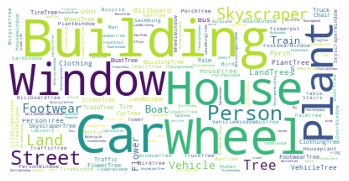

In [ ]:
import jieba
from wordcloud import WordCloud
import imageio
import matplotlib.pyplot as plt
from collections import Counter

#导入一个文本文件
content = poi['language2'].values.tolist()
mylist = list(content)

#对mylist进行遍历,并将其做分词切割后做成列表
word_list = [''.join(jieba.cut(sentence)) for sentence in mylist]

#将word_list内的元素用空格连接起来，以便于计算词频
new_text = ''.join(word_list)

#根据词频生成词云
con_words = [x for x in jieba.cut(new_text) if len(x) >= 2]
fq = Counter(con_words).most_common()
fq = dict(fq)

# #导入背景图片，注意路径
# pac_mask = imageio.imread(r'e:\boy.png')

#设置词云的字体和背景颜色
wc = WordCloud(background_color='white',max_words=2000).fit_words(fq)#,mask=pac_mask
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
#把词云图保存下来
wc.to_file('24.png')
# poi['language2'].values.tolist()

In [20]:
test=poi['CATEGORY'].values.tolist()[0]
test

"['公交车站相关', '美容美发店', '快餐厅', '工厂', '维修站点', '中餐厅', '摩托车维修', '清真菜馆', '美容美发店', '美容美发店']"

In [21]:
eval(test)

['公交车站相关',
 '美容美发店',
 '快餐厅',
 '工厂',
 '维修站点',
 '中餐厅',
 '摩托车维修',
 '清真菜馆',
 '美容美发店',
 '美容美发店']

In [23]:
from collections import Counter
data = eval(test)
c = Counter(data)
c

Counter({'中餐厅': 1,
         '公交车站相关': 1,
         '工厂': 1,
         '快餐厅': 1,
         '摩托车维修': 1,
         '清真菜馆': 1,
         '维修站点': 1,
         '美容美发店': 3})

In [24]:
c.most_common(10)

[('美容美发店', 3),
 ('公交车站相关', 1),
 ('快餐厅', 1),
 ('工厂', 1),
 ('维修站点', 1),
 ('中餐厅', 1),
 ('摩托车维修', 1),
 ('清真菜馆', 1)]

In [25]:
def get_language(test):
  res=[]
  data = eval(test)
  c = Counter(data)
  for i in c.most_common(10):
    res.append(i[0])
  return ' '.join(res).strip()

In [26]:
# poi['language']=['CATEGORY']
poi['language'] = poi.apply(lambda x: get_language(x['CATEGORY100']), axis=1)

## 构建训练对

In [13]:
# CATEGORY	CATEGORY50	CATEGORY100	language2

In [ ]:
!pip install pypinyin

     |████████████████████████████████| 1.3 MB 5.3 MB/s 


In [ ]:
from pypinyin import pinyin, lazy_pinyin, Style
''.join(lazy_pinyin('中心'))

'zhongxin'

In [27]:
pairs=[]
with open('/content/data/poi-sv.txt','w+',encoding='utf-8') as f:
  for index, row in poi.iterrows():
      # print(index) # 输出每行的索引值
      # tmp=eval(row['CATEGORY'])
      # emp=[]
      # for i in tmp:
      #   emp.append(' '.join(i))
      #   #lazy_pinyin(i)
      # f.write(' '.join(emp))

      f.write(row['language'])
      f.write('\t')
      f.write(row['language2'])
      f.write('\n')
      pairs.append(
      [row['language'],row['language2']]
      )

In [28]:
pairs[0]

['物流速递 住宅小区 美容美发店 公司 诊所 乡镇以下级政府及事业单位 中餐厅 汽车维修 路口名 生活服务场所',
 'Tree Plant House Window Car Land Street Billboard Tire']


NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
*******************************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

This is the third and final tutorial on doing "NLP From Scratch", where we
write our own classes and functions to preprocess the data to do our NLP
modeling tasks. We hope after you complete this tutorial that you'll proceed to
learn how `torchtext` can handle much of this preprocessing for you in the
three tutorials immediately following this one.

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]
    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .
... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

**Requirements**



In [29]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




我们需要每个单词有一个唯一的索引，以便稍后用作网络的输入和目标。为了跟踪所有这些，我们将使用一个名为Lang的助手类，该类包含word→ 索引（word2index）和索引→ 单词（index2word）字典，以及每个单词的计数word2count，稍后将用于替换稀有单词

In [30]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [31]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # s = re.sub(r"([.!?])", r" \1", s)
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
pairs[0]

['公交车站相关 美容美发店 快餐厅 工厂 维修站点 中餐厅 摩托车维修 清真菜馆 美容美发店 美容美发店',
 'Tree Plant House Window Car Land Street Billboard Tire']

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [ ]:
normalizeString('武汉大师兄 是多少')

'武汉大师兄 是多少'

这里修改的时候pairs[1] 是空，其实是normalizeString错了

In [32]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

## 修改这个函数

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




因为有很多例句，我们想快速地训练一些东西，所以我们将把数据集精简为相对简短的句子。这里的最大长度是10个单词（包括结尾标点符号），我们将过滤到翻译为“我是”或“他是”等形式的句子（考虑前面替换的撇号）。

我们修改好了，不需要

In [33]:
MAX_LENGTH =11

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH #and \
        # p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [34]:
input_lang, output_lang, pairs = readLangs('poi', 'sv', True)
pairs[0]

Reading lines...


['tree plant house window car land street billboard tire',
 '物流速递 住宅小区 美容美发店 公司 诊所 乡镇以下级政府及事业单位 中餐厅 汽车维修 路口名 生活服务场所']

In [ ]:
filterPairs(pairs[0])

['tree plant house window car land street billboard tire',
 '公交车站相关 美容美发店 快餐厅 工厂 维修站点 中餐厅 摩托车维修 清真菜馆 美容美发店 美容美发店']

In [ ]:
pairs[0][1]

'公交车站相关 美容美发店 快餐厅 工厂 维修站点 中餐厅 摩托车维修 清真菜馆 美容美发店 美容美发店'

In [ ]:
len(pairs[0][1].split(' '))

10

In [ ]:
pairs[0]

['tree plant house window car land street billboard tire',
 '公交车站相关 美容美发店 快餐厅 工厂 维修站点 中餐厅 摩托车维修 清真菜馆 美容美发店 美容美发店']

In [ ]:
filterPair(["i am ", "i m "])

True

In [ ]:
filterPairs(pairs[0])

['tree plant house window car land street billboard tire',
 '公交车站相关 美容美发店 快餐厅 工厂 维修站点 中餐厅 摩托车维修 清真菜馆 美容美发店 美容美发店']

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [ ]:
!wget https://raw.githubusercontent.com/astorfi/sequence-to-sequence-from-scratch/master/data/eng-fra.txt

--2021-08-31 02:56:41--  https://raw.githubusercontent.com/astorfi/sequence-to-sequence-from-scratch/master/data/eng-fra.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9541158 (9.1M) [text/plain]
Saving to: ‘eng-fra.txt.1’

eng-fra.txt.1       100%[===================>]   9.10M  --.-KB/s    in 0.1s    

2021-08-31 02:56:42 (93.2 MB/s) - ‘eng-fra.txt.1’ saved [9541158/9541158]



In [35]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
# filterPairs(pairs)

文件修改

In [36]:
input_lang, output_lang, pairs = readLangs('poi', 'sv', True)

Reading lines...


In [37]:
pairs[0]

['tree plant house window car land street billboard tire',
 '物流速递 住宅小区 美容美发店 公司 诊所 乡镇以下级政府及事业单位 中餐厅 汽车维修 路口名 生活服务场所']

In [ ]:
type(input_lang)

__main__.Lang

In [56]:
input_lang, output_lang, pairs = prepareData('poi', 'sv', True)
print(random.choice(pairs))

Reading lines...
Read 20790 sentence pairs
Trimmed to 20790 sentence pairs
Counting words...
Counted words:
sv 141
poi 384
['tree plant palm person', '生活服务场所 餐饮相关 临街院门 中餐厅 住宅小区 快餐厅 停车场出入口 冷饮店 公司企业 学校']


In [57]:
input_lang.n_words

141

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [38]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [39]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [40]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [41]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [42]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [43]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




整个训练过程看起来像这样。

- 启动一个定时器
- 初始化优化器和准则
- 创建一组训练对
- 启动空的损失数组以进行绘图

然后我们多次调用``train``，并不时地打印进度（到目前为止的例子百分比
的例子，到目前为止的时间，估计时间）和平均损失。

修改它，生成我们需要的loss列表

In [44]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    loss_list=[]

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        loss_list.append(print_loss_total / print_every)

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return (loss_list)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




能不能在这里找到encoder_hidden 或者嵌入向量？找i到单词嵌入？

In [ ]:
evaluate(encoder1, attn_decoder1, pairs[0][0], 11)[1].shape

torch.Size([11, 11])

In [ ]:
evaluate(encoder1, attn_decoder1, pairs[0][0], 11)[2].shape

------
tensor([[ 0.0050,  0.9987, -0.0852,  ...,  0.9898,  0.9306, -0.1805],
        [-0.0349,  0.9982, -0.1514,  ...,  0.9869, -0.9909, -0.1076],
        [ 0.5328, -0.9968, -0.1231,  ...,  0.9869,  0.9844, -0.1183],
        ...,
        [-0.0992, -0.9906, -0.1164,  ...,  0.9796,  0.9732,  0.9416],
        [-0.1001, -0.9898, -0.1171,  ...,  0.9797,  0.9342,  0.9261],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')


torch.Size([11, 256])

In [ ]:
evaluate(encoder1, attn_decoder1,'tree house window plant car wheel', 11)

------
tensor([[ 0.0050,  0.9987, -0.0852,  ...,  0.9898,  0.9306, -0.1805],
        [ 0.3252, -0.9999,  0.4221,  ...,  0.9897,  0.9990, -0.2297],
        [ 0.3524, -0.9745,  0.7969,  ...,  0.9895,  0.9980, -0.9228],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')


(['临街院门',
  '住宅小区',
  '临街院门',
  '临街院门',
  '临街院门',
  '临街院门',
  '临街院门',
  '临街院门',
  '住宅小区',
  '住宅小区',
  '<EOS>'],
 tensor([[1.1605e-05, 2.3282e-05, 9.9980e-01, 5.0843e-07, 3.7539e-08, 6.7308e-06,
          6.8762e-06, 5.0362e-05, 1.6756e-05, 4.8202e-06, 8.1925e-05],
         [1.3764e-03, 7.1089e-04, 3.2003e-04, 1.9484e-04, 1.2371e-06, 9.6058e-01,
          7.7739e-03, 2.3251e-03, 8.7646e-03, 1.7206e-02, 7.4312e-04],
         [7.4651e-02, 5.5732e-04, 8.7867e-04, 1.2296e-03, 8.8658e-01, 4.0239e-03,
          1.0302e-02, 1.9453e-02, 5.4129e-04, 1.2730e-03, 5.0963e-04],
         [1.1019e-04, 2.3588e-02, 1.7183e-03, 5.1203e-03, 1.6542e-04, 9.0337e-01,
          3.1668e-02, 1.1008e-02, 9.8336e-03, 8.6062e-03, 4.8089e-03],
         [8.7327e-06, 4.6483e-03, 1.0945e-03, 7.2392e-03, 1.6048e-05, 9.7418e-01,
          5.4948e-03, 2.9275e-03, 2.3506e-03, 1.5444e-03, 4.9996e-04],
         [3.0531e-05, 4.6507e-03, 4.9169e-03, 1.3617e-02, 6.2447e-04, 9.5077e-01,
          9.4990e-03, 3.9725e-03, 6.2745e

## 试试 会不会变化

In [ ]:
evaluate(encoder1, attn_decoder1, pairs[1][0], 11)[2].shape

------
tensor([[ 0.0050,  0.9987, -0.0852,  ...,  0.9898,  0.9306, -0.1805],
        [ 0.3252, -0.9999,  0.4221,  ...,  0.9897,  0.9990, -0.2297],
        [ 0.1463, -0.9943,  0.4196,  ...,  0.9877, -0.9971, -0.2197],
        ...,
        [-0.1547, -0.8851,  0.3311,  ...,  0.9874,  0.1551,  0.9263],
        [-0.9275, -0.8819,  0.1806,  ...,  0.9874, -0.0907,  0.9342],
        [-0.9277, -0.8668,  0.1795,  ...,  0.9874, -0.0983,  0.9109]],
       device='cuda:0')


torch.Size([11, 256])

evaluate 有输出

In [93]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # print(encoder_outputs)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        print('------')
        print(encoder_outputs)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1],encoder_outputs

evalute 无输出

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # print(encoder_outputs)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # print('------')
        # print(encoder_outputs)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1],encoder_outputs

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [47]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




有了所有这些辅助函数（看起来是额外的工作，但它使运行多个实验更容易），我们实际上可以初始化一个网络并开始训练。
请记住，输入的句子经过了严格的过滤。对于这个小数据集，我们可以使用相对较小的网络，即256个隐藏节点和一个GRU层。在MacBook CPU上大约40分钟后，我们会得到一些合理的结果。
.. 注意：：如果你运行这个笔记本，你可以训练，中断内核，评估，并在以后继续训练。注释掉初始化编码器和解码器的那几行，然后再次运行trainIters。

In [48]:
!nvidia-smi

Wed Sep  1 13:30:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

In [ ]:
train_loss=trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
#新建一个函数记录loss

In [ ]:
with open('/content/drive/MyDrive/loss.text','w+',encoding='utf-8') as f:
  for row in train_loss:
      f.write(str(row))   
      f.write('\n')

In [50]:
encoder1 = torch.load('/content/drive/MyDrive/encoder91')
attn_decoder1 = torch.load('/content/drive/MyDrive/attn_decoder91')
# model.eval()

In [59]:
pairs[0][0]

['tree plant house window car land street billboard tire',
 '物流速递 住宅小区 美容美发店 公司 诊所 乡镇以下级政府及事业单位 中餐厅 汽车维修 路口名 生活服务场所']

### 增加词袋token ID 的方法

In [74]:
evaluate(encoder1, attn_decoder1, 'tree plant house window car land street billboard tire', 11)[0][:-1]

['生活服务场所',
 '生活服务场所',
 '临街院门',
 '临街院门',
 '生活服务场所',
 '物流速递',
 '美容美发店',
 '中餐厅',
 '公交车站相关',
 '公交车站相关']

In [79]:
pairs[0][1]

'物流速递 住宅小区 美容美发店 公司 诊所 乡镇以下级政府及事业单位 中餐厅 汽车维修 路口名 生活服务场所'

In [84]:
evaluate(encoder1, attn_decoder1,pairs[10][0], 11)[0][:-1]

['公司',
 '公司企业',
 '临街院门',
 '物流速递',
 '生活服务场所',
 '公交车站相关',
 '中餐厅',
 '公交车站相关',
 '临街院正门',
 '中餐厅']

In [85]:
pairs[10][1]

'中餐厅 临街院门 生活服务场所 旅馆招待所 住宅小区 公司 住宿服务相关 宾馆酒店 快餐厅 餐饮相关'

In [86]:
print(pairs[15][1])
evaluate(encoder1, attn_decoder1,pairs[15][0], 11)[0][:-1]

生活服务场所 物流速递 住宅小区 培训机构 汽车综合维修 中餐厅 公交车站相关 驾校 快餐厅 临街院门


['生活服务场所',
 '临街院门',
 '住宅小区',
 '临街院门',
 '公交车站相关',
 '中餐厅',
 '物流速递',
 '美容美发店',
 '中餐厅',
 '公司企业']

In [87]:
print(pairs[16][1])
evaluate(encoder1, attn_decoder1,pairs[16][0], 11)[0][:-1]

生活服务场所 住宅小区 中餐厅 物流速递 培训机构 汽车养护 驾校 中国石化 汽车配件销售 汽车综合维修


['生活服务场所',
 '生活服务场所',
 '临街院门',
 '临街院门',
 '生活服务场所',
 '公司',
 '公司企业',
 '中餐厅',
 '住宅小区',
 '美容美发店']

In [81]:
# !pip install rouge-score
from rouge_score import rouge_scorer
# 我们只计算 rouge1 就行
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(' '.join(evaluate(encoder1, attn_decoder1,pairs[0][0], 11)[0][:-1]),
                      pairs[0][1])
# score =rouge_scorer. rougeEvaluationScore(candidate,references)
scores['rouge1']

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [82]:
' '.join(evaluate(encoder1, attn_decoder1,pairs[0][0], 11)[0][:-1])

'生活服务场所 生活服务场所 临街院门 物流速递 临街院门 美容美发店 中餐厅 公交车站相关 公共厕所 公交车站相关'

In [88]:
print(pairs[16][1])
print(pairs[16][0])

生活服务场所 住宅小区 中餐厅 物流速递 培训机构 汽车养护 驾校 中国石化 汽车配件销售 汽车综合维修
tree billboard boat house building person footwear wheel skyscraper


In [91]:
evaluate(encoder1, attn_decoder1, pairs[16][0], 11)[0]

['生活服务场所',
 '生活服务场所',
 '临街院门',
 '临街院门',
 '临街院门',
 '公司',
 '公司企业',
 '中餐厅',
 '住宅小区',
 '美容美发店',
 '<EOS>']

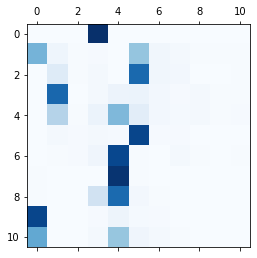

In [89]:
%matplotlib inline
mat=evaluate(encoder1, attn_decoder1, pairs[16][0], 11)[1].numpy()
plt.matshow(mat, cmap=plt.cm.Blues)

------
tensor([[-0.0135,  0.0053,  0.9214,  ..., -0.0549,  0.0619,  0.1896],
        [ 0.0141, -0.0251,  0.9243,  ..., -0.0616, -0.9801,  0.3266],
        [ 0.4219,  0.2004,  0.9337,  ..., -0.3645, -0.9594,  0.1004],
        ...,
        [ 0.2504, -0.0948, -0.8842,  ..., -0.9105, -0.2150,  0.6404],
        [ 0.2549, -0.0674, -0.8279,  ..., -0.8955,  0.1731,  0.6264],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
input = tree plant house window car land street billboard tire
output = 生活服务场所 生活服务场所 临街院门 物流速递 美容美发店 公交车站相关 中餐厅 中餐厅 公共厕所 公交车站相关 <EOS>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27963 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22330 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25152 missing from current font.
  font.set_

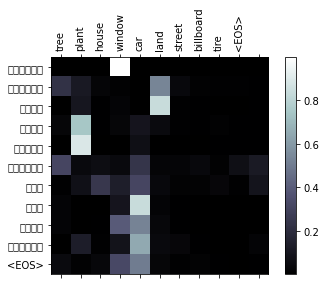

torch.Size([11, 11])


In [97]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
def evaluateAndShowAttention(input_sentence):
    output_words, attentions,out = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

    print(attentions.shape)
evaluateAndShowAttention(pairs[0][0])

In [98]:
# input = tree plant house window car land street billboard tire
# output = 生活服务场所 生活服务场所 临街院门 物流速递 美容美发店 公交车站相关 中餐厅 中餐厅 公共厕所 公交车站相关 <EOS>
pairs[0][1]

'物流速递 住宅小区 美容美发店 公司 诊所 乡镇以下级政府及事业单位 中餐厅 汽车维修 路口名 生活服务场所'

生活服务场所',
 '生活服务场所',
 '临街院门',
 '临街院门',
 '临街院门',
 '公司',
 '公司企业',
 '中餐厅',
 '住宅小区',
 '美容美发店'

In [ ]:
evaluate(encoder1, attn_decoder1, 'window tree house plant building bicycle wheel footwear chair person', 11)

------
tensor([[ 0.0790,  0.0236,  0.8653,  ...,  0.0053,  0.8894, -0.8973],
        [ 0.0685,  0.9930,  0.8529,  ...,  0.8694,  0.9790, -0.8895],
        [ 0.2357, -0.9999,  0.8798,  ...,  0.8694,  0.9998, -0.8848],
        ...,
        [-0.0557, -0.9592, -0.3965,  ..., -0.9988, -0.9985,  0.9242],
        [ 0.1211, -0.9602, -0.3565,  ..., -0.9966, -0.9889,  0.9945],
        [ 0.1798, -0.8808, -0.3669,  ..., -0.9962, -0.9889,  0.9877]],
       device='cuda:0')


(['临街院门', '宿舍', '宿舍', '宿舍', '宿舍', '宿舍', '宿舍', '宿舍', '住宅小区', '住宅小区', '<EOS>'],
 tensor([[2.2393e-06, 3.2467e-06, 9.9996e-01, 4.8955e-07, 4.6633e-09, 9.6390e-07,
          1.6922e-06, 3.1064e-06, 2.7785e-06, 4.2962e-07, 2.5152e-05],
         [3.0125e-04, 4.2988e-03, 1.3938e-02, 4.1878e-04, 7.6659e-05, 9.2005e-01,
          2.6907e-02, 2.6920e-03, 2.1858e-02, 8.6405e-03, 8.1602e-04],
         [1.1196e-06, 9.7818e-01, 3.4284e-03, 3.8725e-05, 7.9162e-05, 6.0511e-03,
          4.3512e-03, 5.0000e-03, 1.7401e-03, 8.3514e-04, 2.9310e-04],
         [4.9101e-08, 9.8860e-01, 1.0897e-03, 3.1485e-04, 1.0150e-03, 2.0957e-03,
          9.9162e-04, 4.7885e-03, 5.5231e-04, 3.9840e-04, 1.5851e-04],
         [1.0063e-07, 9.8104e-01, 4.0160e-03, 1.5332e-04, 8.6301e-03, 1.6908e-03,
          5.5749e-04, 2.8607e-03, 3.9706e-04, 4.2866e-04, 2.2431e-04],
         [1.5419e-07, 9.6955e-01, 1.1856e-02, 1.7590e-03, 7.3301e-03, 6.2769e-03,
          2.1016e-04, 2.0344e-03, 4.2108e-04, 4.3242e-04, 1.3028e-04],
    

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [ ]:
torch.save(encoder1, '/content/drive/MyDrive/encoder1')
torch.save(attn_decoder1, '/content/drive/MyDrive/attn_decoder1')

明天测试 输出中间结果

In [ ]:
encoder1 = torch.load('/content/encoder1')
attn_decoder1 = torch.load('/content/attn_decoder1')
# model.eval()

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

In [ ]:
len(output_words)
output_words

['linjieyuanmen',
 'linjieyuanmen',
 'linjieyuanmen',
 'shenghuofuwuchangsuo',
 'shenghuofuwuchangsuo',
 'shenghuofuwuchangsuo',
 'shenghuofuwuchangsuo',
 'shenghuofuwuchangsuo',
 'shenghuofuwuchangsuo',
 'shenghuofuwuchangsuo',
 '<EOS>']

In [ ]:
pairs[0]

['tree plant house window car land street billboard tire',
 '公交车站相关 美容美发店 快餐厅 工厂 维修站点 中餐厅 摩托车维修 清真菜馆 美容美发店 美容美发店']

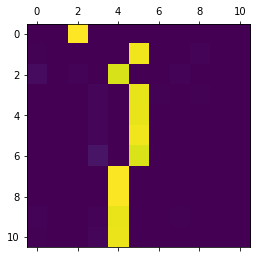

In [ ]:
%matplotlib inline
MAX_LENGTH=10
output_words, attentions = evaluate(
    encoder1, attn_decoder1,pairs[0][0])

plt.matshow(attentions.numpy())
# plt.show()

In [ ]:
pairs[0]

['car tree tree car treecar tree tree tree treecar tree tree tree treetree tree tree tree tree',
 'gongjiaochezhanxiangguan meirongmeifadian kuaicanting gongchang weixiuzhandian zhongcanting motuocheweixiu qingzhencaiguan meirongmeifadian meirongmeifadian']

For a better viewing experience we will do the extra work of adding axes
and labels:




In [ ]:
# attentions.numpy()

input = tree plant house window car land street billboard tire
output = 临街院门 住宅小区 临街院门 临街院门 临街院门 临街院门 住宅小区 住宅小区 住宅小区 住宅小区 <EOS>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34903 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38498 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20303 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23429 missing from current font.
  font.set_

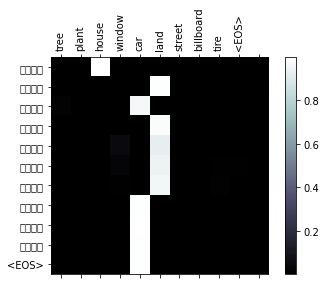

torch.Size([11, 11])


In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

    print(attentions.shape)


evaluateAndShowAttention(pairs[0][0])

input = car tree tree car tree land vehicle truck house
output = 公交车站相关 公交车站相关 公交车站相关 临街院门 临街院门 临街院门 临街院门 临街院门 住宅小区 住宅小区 <EOS>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36710 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20851 missing from current font.
  font.set_

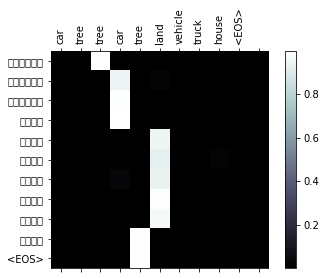

torch.Size([11, 11])


In [ ]:
evaluateAndShowAttention('car tree tree car tree land vehicle truck house')


Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




尝试使用其他数据集
另一对语言
人类→ 机器（如物联网命令）
聊天→ 回应
问题:→ 答复
用预先训练过的单词嵌入替换嵌入，如word2vec或GloVe
尝试使用更多的层次、更多的隐藏单位和更多的句子。比较训练时间和结果。
如果使用一个翻译文件，其中对具有两个相同短语（I am test\t I am test），则可以将其用作自动编码器。试试这个：
作为自动编码器训练
仅保存编码器网络
从那里训练一个新的译码器进行翻译

最后一部分我们来进行精度验证 基于rouge的方法

In [ ]:
from keras.preprocessing.text import Tokenizer

import keras 

tokenizer = Tokenizer()
text = [' '.join(catetypes)]
tokenizer.fit_on_texts(text)

keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(["下 雨 我 加班"]), maxlen=2,padding='post',truncating='post')

In [ ]:
types=['中国人民银行',
 '加油站',
 '教堂',
 '奇瑞维修',
 '洗浴推拿场所',
 '商业贸易',
 '加水站',
 '赛马场',
 '殡仪馆',
 '现代维修',
 '中国移动营业厅',
 '旧货市场',
 '兴业银行ATM',
 '湖泊',
 '住宅区',
 '玛莎拉蒂维修',
 '消费者协会',
 '德国菜',
 '特色/地方风味餐厅',
 '认证事务所',
 '大家乐',
 '出租车',
 '国家级机关及事业单位',
 '特殊买卖场所',
 '普通商场',
 '东风标致维修',
 '一汽大众销售',
 '汽车俱乐部',
 '证券公司',
 '福建菜',
 '卫生院',
 '东风悦达起亚维修',
 '麦德龙',
 '广告装饰',
 '吉利销售',
 '英菲尼迪销售',
 '地税机关',
 '进口现代维修',
 '苏宁',
 '城市广场',
 '福田卡车维修',
 '出入口',
 '邮政速递',
 '社区中心',
 '国美',
 '林肯维修',
 '兽医站',
 '临街院门',
 '中国建设银行',
 '桥',
 '公园广场',
 '妇科医院',
 '阿迪达斯专卖店',
 '一汽丰田销售',
 '传染病医院',
 '吉利维修',
 '迪厅',
 '本田讴歌维修',
 '游泳馆',
 '糕饼店',
 '屈臣氏',
 '湖北菜(鄂菜)',
 '溜冰场',
 '公安警察',
 '宠物诊所',
 '山',
 '中国农业银行ATM',
 '一汽大众奥迪销售',
 '牛扒店(扒房)',
 '进口大众维修',
 '其它个人用品店',
 '交通车辆管理相关',
 '中国银行ATM',
 '台球厅',
 '家电电子卖场',
 '华夏银行ATM',
 '候车室',
 '广汽本田维修',
 '渔场',
 '马术俱乐部',
 '农副产品市场',
 '河流',
 '科研机构',
 '律师事务所',
 '乡镇以下级政府及事业单位',
 '广汽本田销售',
 '建筑物正门',
 '产业园区',
 '福田卡车销售',
 '中国工商银行ATM',
 '巴西菜',
 '沃尔沃维修',
 '站台',
 '公交车站相关',
 '充电站',
 '雷诺销售',
 '图书馆',
 '汽车销售',
 '候机室',
 '宝马维修',
 '公检法机关',
 '东风雪铁龙维修',
 '出站口',
 '羽毛球场',
 '档案馆',
 '三级甲等医院',
 '专科医院',
 '休闲场所',
 '综合市场',
 '中国电信营业厅',
 '新华人寿保险公司',
 '运动场所',
 '街道级地名',
 '货车销售',
 '广汽丰田销售',
 '文化用品店',
 '渣打银行ATM',
 '公共厕所',
 '品牌皮具店',
 '中信银行',
 '快餐厅',
 '郑州日产销售',
 '会计师事务所',
 '泰国/越南菜品餐厅',
 '天文馆',
 '一汽-大众奥迪销售',
 '东风本田维修',
 '家具建材综合市场',
 '体育休闲服务场所',
 '高等院校',
 '电视台',
 '地市级地名',
 '江淮维修',
 '城市快速路出口',
 '花鸟鱼虫市场',
 '彩票彩券销售点',
 '泰康人寿保险公司',
 '人渡口',
 '商务住宅',
 '东风销售',
 '公墓',
 '中国光大银行',
 '精神病医院',
 '甜品店',
 '道路附属设施',
 '交通管理机构',
 '维修站点',
 '报刊亭',
 '采摘园',
 '花卉市场',
 '学校',
 '工业大厦建筑物',
 '呷哺呷哺',
 '梅赛德斯-奔驰销售',
 '户外用品',
 '高速加油站服务区',
 '雪铁龙销售',
 '露营地',
 '一汽解放销售',
 '马自达维修',
 '上海大众销售',
 '凯迪拉克维修',
 '生活服务',
 '肯德基',
 '林场',
 '外地政府办',
 '外国机构相关',
 '网络科技',
 '摩托车销售',
 '科技馆',
 '药房',
 '招商银行ATM',
 'DS维修',
 '沃尔沃销售',
 '小学',
 '名爵销售',
 '医药保健相关',
 '杂志社',
 '公用电话',
 '中国进出口银行',
 '法国兴业银行',
 '马自达销售',
 '华夏银行',
 '日本料理',
 '陵园',
 '吉普维修',
 '综合体育馆',
 '专用停车场',
 '火车站',
 '疾病预防',
 '岛屿',
 '综合家电商场',
 '公交卡/月票代售点',
 '中国邮政储蓄银行ATM',
 '保龄球馆',
 '长途汽车票代售点',
 '雷克萨斯销售',
 '外国使领馆',
 '货运火车站',
 '传媒机构',
 '中介机构',
 '体育休闲服务',
 '麦当劳',
 '学校内部设施',
 '上海浦东发展银行ATM',
 '云贵菜',
 '妇联',
 '雪佛兰销售',
 '停车场出入口',
 '雷诺维修',
 '雷克萨斯维修',
 '医疗保健服务',
 '进口大众销售',
 '收费站',
 '电力营业厅',
 '机场相关',
 '果品市场',
 '楼宇相关',
 '中式素菜馆',
 '福特维修',
 '观致销售',
 '保险公司',
 '道路名',
 '中国人民保险公司',
 '违章停车',
 '珠宝首饰工艺品',
 '海鲜酒楼',
 '中国农业银行',
 '博物馆',
 '壁球场',
 '法拉利维修',
 '住宿服务',
 '宝马销售',
 '中国太平洋保险',
 '动物园',
 '礼品饰品店',
 '斯巴鲁维修',
 '别克维修',
 '诊所',
 '慈善机构',
 '斯巴鲁销售',
 '酒吧',
 '青年旅舍',
 '小商品市场',
 '工商部门',
 '退票',
 '国家级景点',
 '停车场入口',
 '棋牌室',
 '耳鼻喉医院',
 '眼镜店',
 '购物服务',
 '交通银行',
 '女洗手间',
 '宝马MINI维修',
 '植物园',
 '星巴克咖啡',
 '江苏菜',
 '寺庙道观',
 '便民商店/便利店',
 '肿瘤医院',
 '典当行',
 '水族馆',
 '综合医院',
 '职业技术学校',
 '上岛咖啡',
 '中国邮政储蓄银行',
 '摩托车维修',
 '证券营业厅',
 '兰博基尼维修',
 '停车场相关',
 '成人教育',
 '社会治安机构',
 '上海银行ATM',
 '东风标致销售',
 '汇丰银行ATM',
 '一汽-大众维修',
 '劳斯莱斯维修',
 '东风货车销售',
 '乒乓球馆',
 '胸科医院',
 '票务相关',
 '高速路出口',
 '北奔重汽销售',
 '幼儿园',
 '荣威销售',
 '郑州日产维修',
 '游乐场',
 '冷饮店',
 '停车场出口',
 '旅馆招待所',
 '山东菜(鲁菜)',
 '公司',
 '美式风味',
 '加气站',
 '四川菜(川菜)',
 '购物中心',
 '人才市场',
 '中国联通营业厅',
 '医疗保健用品',
 '影剧院相关',
 '游戏厅',
 '道达尔',
 '中国民生银行',
 '立交桥',
 '农村商业银行',
 '婴儿游泳馆',
 '拍卖行',
 '汽车租赁还车',
 '旅游景点',
 '家禽养殖基地',
 '广汽三菱销售',
 '眼科医院',
 '台湾菜',
 '村庄级地名',
 '旅行社',
 '公园景点售票处',
 '中国光大银行ATM',
 '残联',
 '东亚银行',
 '男洗手间',
 '楼栋号',
 '手机销售',
 '电台',
 '中信银行(国际)ATM',
 '江淮货车销售',
 '经济型连锁酒店',
 '信息咨询中心',
 '婴儿服务场所',
 '培训机构',
 '特色商业街',
 '改签',
 '商场',
 '车辆通行证办理处',
 '室内设施',
 '中国人寿保险公司',
 '西餐厅(综合风味)',
 '观致维修',
 'Pacific Coffee Company',
 '音乐厅',
 '美术馆',
 '中国银行',
 '脑科医院',
 '度假村',
 '英菲尼迪维修',
 '平安银行',
 '清真菜馆',
 '服装鞋帽皮具店',
 '矿产公司',
 '海滨浴场',
 '民主党派',
 '汽车维修',
 '工厂',
 '车渡口',
 '交通银行ATM',
 '菲亚特销售',
 '平安银行ATM',
 '公共设施',
 '船票代售点',
 '消防机关',
 '口腔医院',
 '茶艺馆',
 '法国兴业银行ATM',
 '客运港',
 '花卉苗圃基地',
 '金融保险机构',
 '公司企业',
 '售票',
 '城市快速路入口',
 '政府机构及社会团体',
 '服务中心',
 '浙江菜',
 '足球场',
 '银行相关',
 '上海菜',
 '捷豹销售',
 '港口码头',
 '克莱斯勒销售',
 '知名企业',
 '垂钓园',
 '地名地址信息',
 '夜总会',
 '安徽菜(徽菜)',
 '地中海风格菜品',
 '搬家公司',
 '宝马MINI销售',
 '建材五金市场',
 '蔬菜市场',
 '货车维修',
 '行业协会',
 '三星级宾馆',
 '地市级政府及事业单位',
 '中国平安保险公司',
 '国家开发银行',
 '长途汽车站',
 '东风雪铁龙销售',
 '美容美发店',
 '兴业银行',
 '印度风味',
 '政府及社会团体相关',
 '热点地名',
 '摩托车服务相关',
 '高尔夫相关',
 '飞机场',
 '区县级地名',
 '五星级宾馆',
 '汽车服务',
 '休闲餐饮场所',
 '李宁专卖店',
 '自行车专卖店',
 '回教寺',
 '陕西重汽维修',
 '一汽-大众销售',
 '隧道',
 '汽车服务相关',
 '电讯营业厅',
 '三菱销售',
 '进口起亚维修',
 '售票处',
 '中国石油',
 '度假疗养场所',
 '住宅小区',
 '专营店',
 '省级景点',
 '其它农林牧渔基地',
 '电影院',
 '家具城',
 '华泰财产保险股份有限公司',
 '餐饮服务',
 '轮渡站',
 '上海浦东发展银行',
 '中餐厅',
 '东亚银行ATM',
 '林肯销售',
 '中国石化',
 '医药公司',
 '评估事务所',
 '别克销售',
 '保时捷销售',
 '健身中心',
 '路口名',
 '整形美容',
 '摄影冲印',
 '北京华联',
 '法式菜品餐厅',
 '上海大众维修',
 '邮局',
 '交通设施服务',
 '四星级宾馆',
 '生活服务场所',
 '公证鉴定机构',
 '北京现代维修',
 '法拉利销售',
 '路边停车场',
 '陕西重汽销售',
 '丧葬设施',
 '机场货运处',
 '机场出发/到达',
 '科教文化服务',
 '车辆管理机构',
 '农场',
 '起亚销售',
 '耐克专卖店',
 '洗车场',
 '农村商业银行ATM',
 '广发银行',
 '购物相关场所',
 '中国建设银行ATM',
 '纪念馆',
 '综合酒楼',
 '商住两用楼宇',
 '汽车综合维修',
 '风景名胜',
 '高尔夫球场',
 '高速服务区',
 '一汽丰田维修',
 '宠物市场',
 '体育用品店',
 '汽车救援',
 '中国铁通营业厅',
 '意式菜品餐厅',
 '乐天玛特',
 '别墅',
 '北京菜',
 '建筑公司',
 'DS销售',
 '冶金化工',
 '永和豆浆',
 '巴克莱银行ATM',
 '潮州菜',
 '老字号',
 '跆拳道场馆',
 '火车票代售点',
 '步行街',
 '汽车养护',
 '布艺市场',
 '验车场',
 '其它亚洲菜',
 '教会',
 '古玩字画店',
 '乡镇级政府及事业单位',
 '中国工商银行',
 '汇丰银行',
 '东风货车维修',
 '路虎销售',
 '少先队',
 '宿舍',
 '文艺团体',
 '六星级及以上宾馆',
 '电信公司',
 '驾校',
 '进口起亚销售',
 '红十字会',
 '社会团体相关',
 '广汽丰田维修',
 '外国餐厅',
 '品牌服装店',
 '现代销售',
 '东风悦达起亚销售',
 '土特产专卖店',
 '韩国料理',
 '家居建材市场',
 '检察院',
 '保时捷维修',
 '世界遗产',
 '数码电子',
 '骨科医院',
 '高速路入口',
 '北京现代销售',
 '自来水营业厅',
 '乡镇级地名',
 '通行设施',
 '临街院正门',
 '名爵维修',
 '玛莎拉蒂销售',
 '户外健身场所',
 '公园',
 '自动提款机',
 '东风日产销售',
 '商务写字楼',
 '国税机关',
 '三菱维修',
 '奇瑞销售',
 '货运港口码头',
 '江淮销售',
 '中国民生银行ATM',
 '物流速递',
 '凯迪拉克销售',
 '网吧',
 '剧场',
 '公共停车场',
 '洗衣店',
 '餐饮相关',
 '动物医疗场所',
 '摩托车服务',
 '银行',
 '沃尔玛',
 '儿童用品店',
 '高速停车区',
 '东风维修',
 '梅赛德斯-奔驰维修',
 '中信银行ATM',
 '地铁站',
 '宾馆酒店',
 '科教文化场所',
 '高尔夫练习场',
 '钟表店',
 '政府机关相关',
 '飞机票代售点',
 '火锅店',
 '西北菜',
 '一汽-大众奥迪维修',
 '广发银行ATM',
 '省直辖市级政府及事业单位',
 '品牌鞋店',
 '二手车交易',
 '财务公司',
 '法院',
 '卜蜂莲花',
 '厨卫市场',
 '广东菜(粤菜)',
 '水产海鲜市场',
 '专利事务所',
 '红旗维修',
 '网球场',
 '自然地名',
 '共青团',
 '斯柯达维修',
 '招商银行',
 'KTV',
 '茶餐厅',
 '书店',
 '娱乐场所',
 '会展中心',
 '工商税务机构',
 '区县级政府及事业单位',
 '文化宫',
 '展览馆',
 '宠物用品店',
 '金融保险服务',
 '斯柯达销售',
 '交通执法站',
 '进站口/检票口',
 '交通服务相关',
 '水果基地',
 '渣打银行',
 '摄影器材店',
 '华润',
 '滑雪场',
 '中学',
 '音像店',
 '紧急避难场所',
 '机械电子',
 '报社',
 '商务住宅相关',
 '雪佛兰维修',
 '大众销售',
 '篮球场馆',
 '必胜客',
 '东风本田销售',
 '东北菜',
 '住宿服务相关',
 '事务所',
 '行李查询/行李问询',
 '疗养院',
 '吉普销售',
 '其它能源站',
 '进口现代销售',
 '物流仓储场地',
 '普通地名',
 '咖啡厅',
 '灯具瓷器市场',
 '超市',
 '宾利销售',
 '福特销售',
 '建筑物门',
 '急救中心',
 '汽车配件销售',
 '出版社',
 '劳斯莱斯销售',
 '湖南菜(湘菜)',
 '汽车租赁',
 '门牌信息',
 '东风日产维修',
 '水上活动中心',
 '医疗保健服务场所',
 '烟酒专卖店']